## Imports 

In [1]:
import io
import re
import json
import requests
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import matplotlib.colors as colors
from pandas.io.json import json_normalize

# graphing 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline


### Install Imports then Import them!

In [3]:
# import folium if cant install then import
try:
    import folium
except:
    !pip install folium
    print("installed {}".format('folium'))
    import folium
    
# import wikipedia if cant install then import
try:
    import wikipedia as wp
except:
    !pip install wikipedia
    print("installed {}".format('wikipedia'))
    import wikipedia

# zip code stuff
try:
    import uszipcode
except:
    !pip install uszipcode
    print("installed {}".format('uszipcode'))
    import uszipcode
    
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

# graph imports 
try:
    import geopy 
    from geopy.geocoders import Nominatim
except:
    !pip install geopy
    print("installed {}".format('geopy'))
    import geopy 
    from geopy.geocoders import Nominatim

# learn imports
try:
    import seaborn as sns
except:
    !pip install seaborn
    print("installed {}".format('seaborn'))
    import seaborn as sns
    
from sklearn.cluster import KMeans


### Declare City List

In [4]:
city_list = [
    'Baltimore',
    'Baltimore County',
    'Richmond',
    'Henrico County',
    'Phoenix',
    'Maricopa County',
    'Houston',
    'Harris County'
]

### Declare City List with State

In [5]:
city_state = [
    ['Baltimore', 'Maryland'],
    ['Baltimore County', 'Maryland'],
    ['Richmond', 'Virginia'],
    ['Henrico County', 'Virginia'],
    ['Phoenix', 'Arizona'],
    ['Maricopa County', 'Arizona'],
    ['Houston', 'Texas'],
    ['Harris County', 'Texas']
]

### Declare Codinates DataFrame

In [6]:
header = ['City', 'Latitude', 'Longitude']
comb = [
    ['Baltimore', 39.283333, -76.616667],
    ['Baltimore County', 39.4, -76.6],
    ['Richmond', 37.533333, -77.466667],
    ['Henrico County', 37.55, -77.4],
    ['Phoenix', 33.45, -112.066667],
    ['Maricopa County', 33.513889, -112.475833],
    ['Houston', 29.762778, -95.383056],
    ['Harris County', 29.86, -95.39]
]

tempC = []
tempLat = []
tempLong = []
for c in comb:
    tempC.append(c[0])
    tempLat.append(c[1])
    tempLong.append(c[2])

#NDF = new dataframe
NDF = {
    str(header[0]): tempC,
    str(header[1]): tempLat,
    str(header[2]): tempLong
}

# CDF = cords dataframe
CDF = pd.DataFrame(NDF, columns = ['City', 'Latitude', 'Longitude'])

cities = CDF[header[0]]
lat = CDF[header[1]]
long = CDF[header[2]]

### Foursquare Creds

In [7]:
CLIENT_ID = 'TL2E0LDIYOXQH22H13SIGIGDAZRVEF4HCZSM0KQ2XJKXDHKK' # foursquare ID
CLIENT_SECRET = 'U0YKWNDNGW22DNPJMM4CXUKRDMJH2CII0PPRFISGL3HZLUHP' # foursquare Secret
VERSION = '20200712'
LIMIT = 100

### Initialize Maps V1

In [8]:
# lets start with the 4 main cities
#print(cities)
#print(lat)
#print(long)

baltimore_city_map = folium.Map(location=[lat[0], long[0]], zoom_start=10)
baltimore_county_map = folium.Map(location=[lat[1], long[1]], zoom_start=10)
richmond_city_map = folium.Map(location=[lat[2], long[2]], zoom_start=10)
henrico_county_map = folium.Map(location=[lat[3], long[3]], zoom_start=10)
phoenix_city_map = folium.Map(location=[lat[4], long[4]], zoom_start=10)
maricopa_county_map = folium.Map(location=[lat[5], long[5]], zoom_start=10)
houston_city_map = folium.Map(location=[lat[6], long[6]], zoom_start=10)
harris_county_map = folium.Map(location=[lat[7], long[7]], zoom_start=10)

# lc = location class
# add them all to a list
maps = [
    baltimore_city_map, # lc1
    baltimore_county_map, # lc1
    richmond_city_map, # lc2
    henrico_county_map, # lc2
    phoenix_city_map, # lc3
    maricopa_county_map, # lc3
    houston_city_map, # lc4
    harris_county_map # lc4
]

### Function to get Zipcodes based on range OLD

In [66]:
"""
OLD
# gzcr = getZipCodeRange
# might not need this
def gzcr(startN, endN):
    l1 = [] # list 1
    addrRange = range(startN, endN + 1)
    for val in addrRange:
        l1.append(val)
        
    return l1
"""

### Make master Zipcode list OLD

In [95]:
"""
OLD
zipList = [
    [21201, 21298], # lc1
    []
]
"""

'\nzipList = [\n    [21201, 21298], # lc1\n    []\n]\n'

### Get all Zips

In [9]:
all_zip = []

# search for all the zips and add them to a list
for cs in city_state:
    temp1 = search.by_city_and_state(cs[0], cs[1])
    for t in temp1:
        tempL = [cs[0]]
        tempL.append(t.zipcode)
        if len(t.common_city_list) != 0:
            tempL.append(t.common_city_list[-1])
        else:
            tempL.append(cs[0]+'?')
        tempL.append(t.lat)
        tempL.append(t.lng)
        all_zip.append(tempL)

# format for all_zip [[city, zip, common city, lat, long]]

# remove the none from the cord and put the previous val in
prevE = []
for az in all_zip:
    if az[3] == None:
        az[3] = prevE[-1][0]
    if az[4] == None:
        az[4] = prevE[-1][-1]
    
    temp = [az[3], az[4]]
    prevE.append(temp)
    


### Turn all_zips into a DataFrame

In [17]:
header = ['City', 'Zip', 'Common City', 'Latitude', 'Longitude']
TC = []
TZ = []
TCC = []
TLo = []
TLa = []

for az2 in all_zip:
    TC.append(az2[0])
    TZ.append(az2[1])
    TCC.append(az2[2])
    TLo.append(az2[3])
    TLa.append(az2[4])

tNDF = {
    header[0]:TC,
    header[1]:TZ,
    header[2]:TCC,
    header[3]:TLo,
    header[4]:TLa
}

all_zipDF = pd.DataFrame(tNDF, columns = ['City', 'Zip', 'Common City', 'Latitude', 'Longitude'])

all_zipDF.head()

,City,Zip,Common City,Latitude,Longitude
0,Baltimore,21201,Baltimore,39.29,-76.62
1,Baltimore,21202,East Case,39.30,-76.61
2,Baltimore,21205,Baltimore,39.30,-76.57
3,Baltimore,21206,Raspeburg,39.34,-76.54
4,Baltimore,21209,Mt Washington,39.37,-76.68


### Make Labels

In [10]:
labels = []
for c in cities:
    temp = folium.Popup(c)
    labels.append(temp)

### Make Circle Markers

In [11]:
# cm = Circle Markers
cm = []

x = 0

while x != 8:
    folium.CircleMarker(
        [lat[x], long[x]],
        radius=5,
        popup=labels[x],
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(maps[x])
    x += 1

### Initialize Maps V2

In [24]:
# all_zipDF
# centers with baltimore
addr = 'Baltimore'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(addr)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

main_map2 = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, city, CC in zip(all_zipDF['Latitude'], all_zipDF['Longitude'], all_zipDF['City'], all_zipDF['Common City']):
    label = '{}, {}'.format(city, CC)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(main_map2)

    
main_map2

### Get Category Function

In [19]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Get Venues

In [20]:
# FourSqure url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, 500, LIMIT)

results = requests.get(url).json()
results

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

#dataframe.head()

# keep only columns that include venue name, and anything that is associated with location
fc = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, fc]

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Baltimore City Hall,City Hall,100 Holliday St,US,Baltimore,United States,btw Fayette & Lexington,34,"[100 Holliday St (btw Fayette & Lexington), Ba...","[{'label': 'display', 'lat': 39.29084152348969...",39.290842,-76.610366,21202,MD,4ae1da9df964a520fb8721e3
1,The Block,Plaza,400 blk of E Baltimore St,US,Baltimore,United States,btwn Commerce & Gay,180,[400 blk of E Baltimore St (btwn Commerce & Ga...,"[{'label': 'display', 'lat': 39.2898184715289,...",39.289818,-76.609180,21202,MD,4b7b5ab1f964a5209d5f2fe3
2,"Clarence ""Du"" Burns Council Chambers",City Hall,100 Holliday St,US,Baltimore,United States,btw E Fayette St & E Lexington St,19,[100 Holliday St (btw E Fayette St & E Lexingt...,"[{'label': 'display', 'lat': 39.29088592529297...",39.290886,-76.610535,21202,MD,4c752a431b30a093907eee09
3,The Benton Building,Building,417 E Fayette St,US,Baltimore,United States,at N Gay St,133,"[417 E Fayette St (at N Gay St), Baltimore, MD...","[{'label': 'display', 'lat': 39.29047054068511...",39.290471,-76.609299,21202,MD,4bbccf56f57ba5938945adb9
4,Baltimore City Courthouse East,Courthouse,111 N Calvert St,US,Baltimore,United States,at E Fayette St,130,"[111 N Calvert St (at E Fayette St), Baltimore...","[{'label': 'display', 'lat': 39.29074385639603...",39.290744,-76.612261,21202,MD,4bb4e9cab1edef3bb84a2cdd


### Function to get venues

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
        
    return(nearby_venues)

### List all nearby venues

In [23]:
all_venues = getNearbyVenues(names=all_zipDF['City'],
                                   latitudes=all_zipDF['Latitude'],
                                   longitudes=all_zipDF['Longitude']
                                  )



### Venues

In [25]:
print('{} Venues were returned by Foursquare.'.format(all_venues.shape[0]))

585 Venues were returned by Foursquare.


### Number of venues per Neighborhood

In [26]:
all_venues.groupby('City').count()

,City Latitude,Cirt Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Baltimore,112,112,112,112,112,112
Baltimore County,112,112,112,112,112,112
Harris County,15,15,15,15,15,15
Henrico County,54,54,54,54,54,54
Houston,104,104,104,104,104,104
Phoenix,140,140,140,140,140,140
Richmond,48,48,48,48,48,48


In [27]:
# unique categories
print('There are {} uniques categories.\n\n'.format(len(all_venues['Venue Category'].unique())))

# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_onehot['City'] = all_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [all_onehot.columns[-1]] + list(all_onehot.columns[:-1])
manhattan_onehot = all_onehot[fixed_columns]

all_onehot.head()

all_grouped = all_onehot.groupby('City').mean().reset_index()
all_grouped.head()

There are 156 uniques categories.




,City,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,...,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Baltimore,0.0,0.008929,0.026786,0.0,0.000000,0.000000,0.000000,0.008929,0.000000,...,0.008929,0.044643,0.0,0.000000,0.000000,0.0,0.0,0.017857,0.000000,0.000000
1,Baltimore County,0.0,0.008929,0.026786,0.0,0.000000,0.000000,0.000000,0.008929,0.000000,...,0.008929,0.044643,0.0,0.000000,0.000000,0.0,0.0,0.017857,0.000000,0.000000
2,Harris County,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.066667,0.000000
3,Henrico County,0.0,0.000000,0.018519,0.0,0.018519,0.000000,0.000000,0.000000,0.018519,...,0.018519,0.000000,0.0,0.018519,0.000000,0.0,0.0,0.000000,0.000000,0.018519
4,Houston,0.0,0.000000,0.009615,0.0,0.000000,0.009615,0.009615,0.019231,0.000000,...,0.019231,0.009615,0.0,0.000000,0.009615,0.0,0.0,0.000000,0.009615,0.000000


### Return common venues

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Top Venues

In [29]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create the columns according to number of top venues
columns = ['City']

for ind in np.arange(num_top_venues):
    try: 
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)

neighborhoods_venues_sorted['City'] = all_grouped['City']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)


    
neighborhoods_venues_sorted.head()


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baltimore,Café,Sandwich Place,Pizza Place,Coffee Shop,Hotel
1,Baltimore County,Café,Sandwich Place,Pizza Place,Coffee Shop,Hotel
2,Harris County,Coffee Shop,Pool,Jazz Club,Hostel,Pub
3,Henrico County,Coffee Shop,Jewelry Store,Cosmetics Shop,Mobile Phone Shop,Mexican Restaurant
4,Houston,Coffee Shop,Bar,Gym,Gym / Fitness Center,Rental Car Location


### Get Population & Population Density

In [30]:
Pheader = ['City', 'Zip', 'Population', 'Population Density']
Pcity = all_zipDF['City']
Pzip = all_zipDF['Zip']
popL = []
popDL = []

for z in Pzip:
    temp = search.by_zipcode(z)
    pop = temp.population
    popD = temp.population_density
    
    #print("{} || pop: {} || pop dense {}\n".format(z, temp.population, temp.population_density))

    if pop != None or popD != None:
        popL.append(pop)
        popDL.append(popD)
    else:
        popL.append(np.nan)
        popDL.append(np.nan)
        
popNDF = {
    Pheader[0]: Pcity,
    Pheader[1]: Pzip,
    Pheader[2]: popL,
    Pheader[3]: popDL
}

popDF = pd.DataFrame(popNDF, columns = ['City', 'Zip', 'Population', 'Population Density'])
popDF = popDF.dropna()
popDF


,City,Zip,Population,Population Density
0,Baltimore,21201,16972.0,13158.0
1,Baltimore,21202,22832.0,14384.0
2,Baltimore,21205,16146.0,7883.0
3,Baltimore,21206,50846.0,7055.0
4,Baltimore,21209,26465.0,3734.0
5,Baltimore County,21201,16972.0,13158.0
6,Baltimore County,21202,22832.0,14384.0
7,Baltimore County,21205,16146.0,7883.0
8,Baltimore County,21206,50846.0,7055.0
9,Baltimore County,21209,26465.0,3734.0


### Get Minium Function

In [31]:
def getMin(l1): # l1 is a list
    #print(min(l1))
    return min(l1)

### Get Maxium Function

In [32]:
def getMax(l1): # l1 is a list
    #print(max(l1))
    return max(l1)

### Plot testing

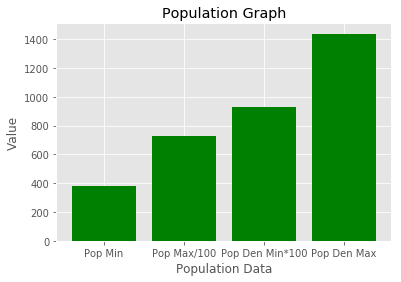

In [33]:
p = popDF
TP = p['Population']
TPD = p['Population Density']

TP_min = getMin(TP)
TP_max = getMax(TP)
TPD_min = getMin(TPD)
TPD_max = getMax(TPD)
bg = [TP_min/10, TP_max/100, TPD_min*10, TPD_max/10] # bar graph data
x = ['Pop Min', 'Pop Max/100', 'Pop Den Min*100', 'Pop Den Max']

plt.style.use('ggplot')

x_pos = [i for i, _ in enumerate(bg)]

plt.bar(x_pos, bg, color='green')

plt.xticks(x_pos, x)
plt.xlabel('Population Data')
plt.ylabel('Value')
plt.title('Population Graph')
plt.show()

### Get all Venue Categories

In [34]:
mlv = [] # master venue list

x = 0
for y in all_venues['Venue Category']:
    if y not in mlv:
        mlv.append(y)
    x += 1

In [46]:
mlv

['Portuguese Restaurant',
 'Theater',
 'Monument / Landmark',
 'Sandwich Place',
 'Fish Market',
 'Breakfast Spot',
 'Afghan Restaurant',
 'Coffee Shop',
 'Peruvian Restaurant',
 'Italian Restaurant',
 'Pizza Place',
 'Food Truck',
 'BBQ Joint',
 'Café',
 'Hotel',
 'Deli / Bodega',
 'Vietnamese Restaurant',
 'New American Restaurant',
 'Church',
 'Liquor Store',
 'Hotel Bar',
 'Ethiopian Restaurant',
 'Indian Restaurant',
 'Bakery',
 'Dog Run',
 'Boarding House',
 'Gastropub',
 'Gym / Fitness Center',
 'Thai Restaurant',
 'French Restaurant',
 'Rental Car Location',
 'Convenience Store',
 'Bank',
 'Farmers Market',
 'Donut Shop',
 'Pharmacy',
 'Plaza',
 'Mexican Restaurant',
 'American Restaurant',
 'Seafood Restaurant',
 'Museum',
 'Nightclub',
 'Stadium',
 'Credit Union',
 'Metro Station',
 'Chinese Restaurant',
 'Lounge',
 'Bus Stop',
 'Gift Shop',
 'Steakhouse',
 'Gym',
 'Greek Restaurant',
 'Bar',
 'Brewery',
 'Park',
 'Fried Chicken Joint',
 'Gas Station',
 'Fast Food Restaurant'

### Get all Restaurants Categories

In [83]:
h1 = list(all_grouped.columns)

RC = [] # RC means Restaurants Categories
# ask the user to verify if its a restaurant
for h in h1:
    print("Is {} a Restaurant?".format(h))
    check1 = input('y for yes or n for no:\t')
    
    if check1 == 'y':
        RC.append(h)
        
len(RC)

Is City a Restaurant?
y for yes or n for no:	n
Is Accessories Store a Restaurant?
y for yes or n for no:	n
Is Afghan Restaurant a Restaurant?
y for yes or n for no:	y
Is American Restaurant a Restaurant?
y for yes or n for no:	y
Is Art Gallery a Restaurant?
y for yes or n for no:	n
Is Arts & Entertainment a Restaurant?
y for yes or n for no:	n
Is Asian Restaurant a Restaurant?
y for yes or n for no:	y
Is Athletics & Sports a Restaurant?
y for yes or n for no:	n
Is BBQ Joint a Restaurant?
y for yes or n for no:	y
Is Bagel Shop a Restaurant?
y for yes or n for no:	y
Is Bakery a Restaurant?
y for yes or n for no:	y
Is Bank a Restaurant?
y for yes or n for no:	n
Is Bar a Restaurant?
y for yes or n for no:	y
Is Basketball Court a Restaurant?
y for yes or n for no:	n
Is Basketball Stadium a Restaurant?
y for yes or n for no:	n
Is Beer Bar a Restaurant?
y for yes or n for no:	y
Is Beer Garden a Restaurant?
y for yes or n for no:	y
Is Boarding House a Restaurant?
y for yes or n for no:	n
Is Bo

y for yes or n for no:	y
Is Thai Restaurant a Restaurant?
y for yes or n for no:	y
Is Theater a Restaurant?
y for yes or n for no:	n
Is Theme Restaurant a Restaurant?
y for yes or n for no:	y
Is Thrift / Vintage Store a Restaurant?
y for yes or n for no:	n
Is Trail a Restaurant?
y for yes or n for no:	n
Is Train Station a Restaurant?
y for yes or n for no:	n
Is Vegetarian / Vegan Restaurant a Restaurant?
y for yes or n for no:	y
Is Vietnamese Restaurant a Restaurant?
y for yes or n for no:	y
Is Wine Bar a Restaurant?
y for yes or n for no:	y
Is Wine Shop a Restaurant?
y for yes or n for no:	n


66

### Get all Venue names with the correct Category

In [104]:
# get from dataframe_filtered['name']
#dataframe_filtered.tail()

h3 = list(all_venues.columns)
restaurants1 = []

for index, row in all_venues.iterrows():
    if row[6] in RC:
        restaurants1.append(list(row))

#restaurants1
rd = pd.DataFrame(restaurants1, columns = h3)
rd.head()
RV = rd

### Map all Restaurants

In [107]:
fm = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, city, name in zip(RV['Venue Latitude'], RV['Venue Longitude'], RV['City'], RV['Venue']):
    label = '{}, {}'.format(city, name)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(fm)
fm